# Fashion MNIST classification using PyTorch

In this notebook we will try to classify the Fashion MNIST dataset
(https://github.com/zalandoresearch/fashion-mnist) using CNN. 

## Fashion MNIST

This 10 class dataset is a drop-in replacement for MNIST with clothes instead of digits. Fashion MNIST is subtancially harder to classify.

![fashion_mnist](https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png)

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.cm import get_cmap
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

Some system/model hyper parameters

In [4]:
cuda = False  # We don't use GPU for now.
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [3]:
english_labels = ["T-shirt/top",
                  "Trouser",
                  "Pullover",
                  "Dress",
                  "Coat",
                  "Sandal",
                  "Shirt",
                  "Sneaker",
                  "Bag",
                  "Ankle boot"]

train_data = datasets.FashionMNIST('data', train=True, download=True,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                   ]))
train_loader = DataLoader(train_data, batch_size=128, shuffle=False, **kwargs)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Lets's compute the average mean and std of the train images. We will
use them for normalizing data later on.

In [5]:
n_samples_seen = 0.
mean = 0
std = 0
for train_batch, train_target in train_loader:
    batch_size = train_batch.shape[0]
    train_batch = train_batch.view(batch_size, -1)
    this_mean = torch.mean(train_batch, dim=1)
    this_std = torch.sqrt(
        torch.mean((train_batch - this_mean[:, None]) ** 2, dim=1))
    mean += torch.sum(this_mean, dim=0)
    std += torch.sum(this_std, dim=0)
    n_samples_seen += batch_size

mean /= n_samples_seen
std /= n_samples_seen

In [7]:
print(mean, std)

tensor(0.2860) tensor(0.3202)


We now reload the data with a further `Normalize` transform

In [6]:
train_data = datasets.FashionMNIST('data', train=True, download=False,
                                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean.view(1),
                                                            std=std.view(1))]))

test_data = datasets.FashionMNIST('data', train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean.view(1),
                                                           std=std.view(1))]))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=32,
                                          shuffle=False, **kwargs)


We define a very simple model, suitable for **CPU** training

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=(3, 3), padding=1)
        self.dropout_2d = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(7 * 7 * 20, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.dropout_2d(F.max_pool2d(self.conv1(x), kernel_size=2))
        x = self.dropout_2d(F.max_pool2d(self.conv2(x), kernel_size=2))
        x = x.view(-1, 7 * 7 * 20)  # flatten / reshape
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

In [10]:
# %load solutions/vgg.py

Let's test our model on CPU

In [11]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=tensor([0.2860]), std=tensor([0.3202]))
           )

In [12]:
model = Model()
img, target = train_data[0]
# n_channel, width, height
print(img.shape)

# First dimension should contain batch_size


torch.Size([1, 28, 28])


We can plot a training image

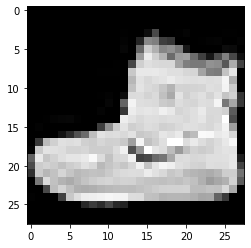

In [13]:
fig, ax = plt.subplots(1, 1)
ax.imshow(img[0].numpy(), cmap=get_cmap('gray'))
plt.show()

The first dimension of the input data should contain the batch size (due to `torch.nn` API)

In [14]:
img.shape

torch.Size([1, 28, 28])

In [15]:
pred = model(img[None, :])
print(target, english_labels[target])
print(pred)

9 Ankle boot
tensor([[-2.8666, -2.0378, -1.8569, -2.8195, -2.2856, -2.4557, -2.3615, -2.1391,
         -2.3877, -2.2482]], grad_fn=<LogSoftmaxBackward0>)


We define a train loop

In [16]:
def train(model, optimizer, train_loader, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        batch_size = data.shape[0]
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_size

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(test_loader.dataset)
    return train_loss

And a test function:

In [17]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # sum up batch loss
            _, pred = output.data.max(dim=1)
            # get the index of the max log-probability
            correct += torch.sum(pred == target.data.long()).item()

        test_loss /= len(test_loader.dataset)
        test_accuracy = float(correct) / len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f},'
              ' Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * test_accuracy))
    return test_loss, test_accuracy

The `find_lr` function provides a learning rate for SGD or Adam, following heuristics from https://arxiv.org/abs/1506.01186:

In [18]:
import numpy as np

def loop_loader(data_loader):
    while True:
        for elem in data_loader:
            yield elem

def find_lr(model, train_loader, init_lr, max_lr, steps, n_batch_per_step=30):
    optimizer = torch.optim.SGD(model.parameters(), lr=init_lr)
    current_lr = init_lr
    best_lr = current_lr
    best_loss = float('inf')
    lr_step = (max_lr - init_lr) / steps

    loader = loop_loader(train_loader)
    for i in range(steps):
        mean_loss = 0
        n_seen_samples = 0
        for j, (data, target) in enumerate(loader):
            if j > n_batch_per_step:
                break
            optimizer.zero_grad()
            if cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            mean_loss += loss.item() * data.shape[0]
            n_seen_samples += data.shape[0]
            optimizer.step()

        mean_loss /= n_seen_samples
        print('Step %i, current LR: %f, loss %f' % (i, current_lr, mean_loss))
            
        if np.isnan(mean_loss) or mean_loss > best_loss * 4:
            return best_lr / 4
        
        if mean_loss < best_loss:
            best_loss = mean_loss
            best_lr = current_lr

        current_lr += lr_step
        optimizer.param_groups[0]['lr'] = current_lr

    return best_lr / 4

Let's load our model on the GPU if required. We then define an optimizer and a learning rate scheduler

In [19]:
log_interval = 100
epochs = 12

In [20]:
if cuda:
    model.cuda()

model.reset_parameters()
lr = find_lr(model, train_loader, 1e-4, 1, 100, 30)
model.reset_parameters()

print('Best LR', lr)

Step 0, current LR: 0.000100, loss 2.312639
Step 1, current LR: 0.010099, loss 2.284550
Step 2, current LR: 0.020098, loss 2.126925
Step 3, current LR: 0.030097, loss 1.483948
Step 4, current LR: 0.040096, loss 1.132642
Step 5, current LR: 0.050095, loss 1.069451
Step 6, current LR: 0.060094, loss 0.961364
Step 7, current LR: 0.070093, loss 0.918051
Step 8, current LR: 0.080092, loss 0.896984
Step 9, current LR: 0.090091, loss 0.781348
Step 10, current LR: 0.100090, loss 0.841834
Step 11, current LR: 0.110089, loss 0.748274
Step 12, current LR: 0.120088, loss 0.792290
Step 13, current LR: 0.130087, loss 0.759032
Step 14, current LR: 0.140086, loss 0.696000
Step 15, current LR: 0.150085, loss 0.741978
Step 16, current LR: 0.160084, loss 0.675573
Step 17, current LR: 0.170083, loss 0.681440
Step 18, current LR: 0.180082, loss 0.635259
Step 19, current LR: 0.190081, loss 0.690068
Step 20, current LR: 0.200080, loss 0.596205
Step 21, current LR: 0.210079, loss 0.659771
Step 22, current LR:

Let's train our model:

In [25]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                       T_max=3,
                                                       last_epoch=-1)

logs = {'epoch': [], 'train_loss': [], 'test_loss': [],
        'test_accuracy': [], 'lr': []}

In [26]:
for epoch in range(epochs):
    train_loss = train(model, optimizer, train_loader, epoch)
    test_loss, test_accuracy = test(model, test_loader)
    logs['epoch'].append(epoch)
    logs['train_loss'].append(train_loss)
    logs['test_loss'].append(test_loss)
    logs['test_accuracy'].append(test_accuracy)
    logs['lr'].append(optimizer.param_groups[0]['lr'])
    scheduler.step(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.435000
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.385893
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.556447
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.513696
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.380164
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.419992
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.494421
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.486652
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.441213


KeyboardInterrupt: ignored

## Exercices

- Define a VGG or ResNet model, and train your network using **GPU**.
- (optional) Try data augmentation (horizontal flips, random crops, cutout...);
- (optional) Try to use batch-normalization;
- (optional) Implement skip-connections.

See how you compare to other approaches:
- https://github.com/zalandoresearch/fashion-mnist
- https://www.kaggle.com/zalando-research/fashionmnist